In [73]:
import os
import sys
import sqlite3
import numpy as np
import pandas as pd
import geopandas as gp
import plotly.express as px
import skill_metrics as sm
import skill_metrics as sm
import matplotlib.pyplot as plt
import scipy.stats as scs

import spei

In [74]:
sys.path.append('/home/pooya/w/DroughtMonitoringIran/')

DATABASE_PATH = "./database/database.db"

### Monthly Data

In [75]:
conn = sqlite3.connect(DATABASE_PATH)

data = pd.read_sql(sql='SELECT * FROM data', con=conn)

data['Date'] = pd.to_datetime(data["Date"], format="%Y-%m")

conn.close()

### Unique Station

In [76]:
data[['Station_ID', 'Station_Name']].drop_duplicates().reset_index(drop=True)

,Station_ID,Station_Name
0,40709,Astara
1,40718,Bandar-e-anzali
2,40719,Rasht
3,40720,Manjil
4,40732,Ramsar
5,40734,Nowshahr
6,40735,Siahbisheh
7,40736,Babolsar
8,40737,Gharakhil
9,40759,Sari


### Select Stations
- Cluster 3 - Bandar-e-anzali:  40718  
- Cluster 1 - Gharakhil:        40737  
- Cluster 2 - Siahbisheh:       40735  

In [77]:
selected_stations = ["Bandar-e-anzali", "Gharakhil", "Siahbisheh"]

### Selected Colmns

In [78]:
scale = 12
di = 'SPEI'

sf = [
    'Station_ID',
    'Station_Name',
    'Date',
    'NDVI',
    'EVI',
    'PCI_GPM',
    'VCI',
    'TCI',
    'VHI',
    'CI_GPM',
    f'{di}_{scale}',
    f'GPM_{di}_{scale}'
]

### Filter Data

In [79]:
df = data[sf].query('Station_Name in @selected_stations')

### Plot

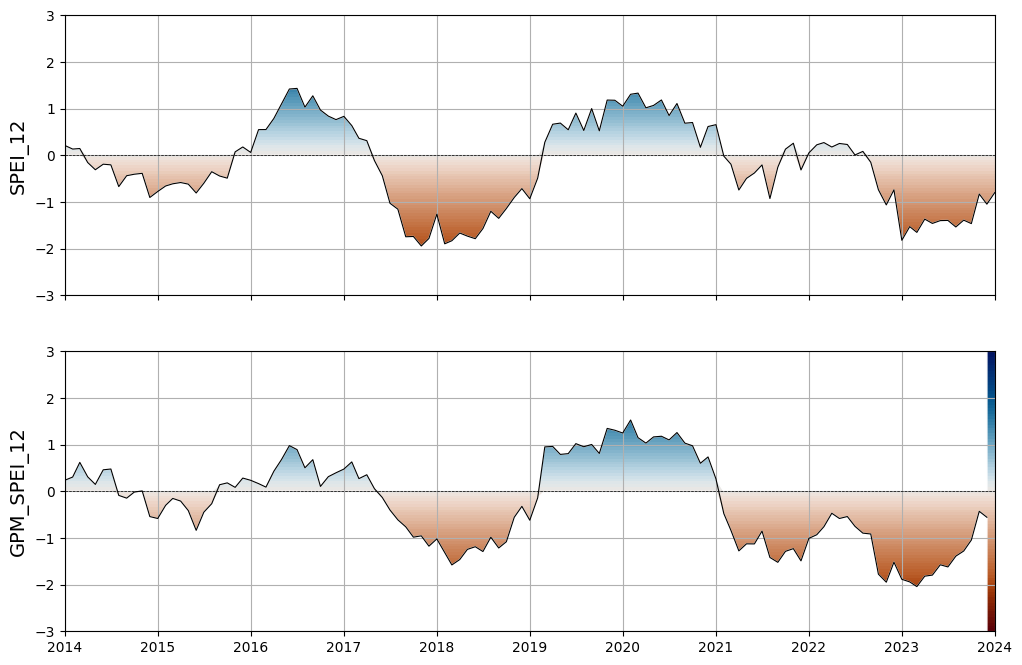

In [80]:
df_plot = df.query('Station_Name == "Gharakhil"')
df_plot.set_index('Date', inplace=True)

f, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
spei.plot.si(df_plot[f'{di}_{scale}'], ax=ax[0], cmap="vik_r")
spei.plot.si(df_plot[f'GPM_{di}_{scale}'], ax=ax[1], cmap="vik_r")
ax[0].set_xlim(pd.to_datetime(["2014", "2024"]))
[x.grid() for x in ax]
[ax[i].set_ylabel(n, fontsize=14) for i, n in enumerate([f'{di}_{scale}', f'GPM_{di}_{scale}'])];

### Calculate Model Evaluator

In [81]:
from utils.model_evaluator import ModelEvaluator

for st in selected_stations:
    print(f"\nMetrics for Station ID: {st}")
    ModelEvaluator(df.query('Station_Name == @st'), f'{di}_{scale}', f'GPM_{di}_{scale}').display_metrics()


Metrics for Station ID: Bandar-e-anzali
Model Performance Metrics:
Mean Absolute Error (MAE): 0.4612
Mean Squared Error (MSE): 0.3247
Root Mean Squared Error (RMSE): 0.5698
R-squared (R2): 0.6831
Explained Variance Score: 0.6838
Willmott's Index of Agreement (WI): 0.7168
Nash–Sutcliffe Efficiency (NS): 0.6831
Mean Absolute Deviation (MAD): 0.4612

Metrics for Station ID: Gharakhil
Model Performance Metrics:
Mean Absolute Error (MAE): 0.4014
Mean Squared Error (MSE): 0.2536
Root Mean Squared Error (RMSE): 0.5036
R-squared (R2): 0.7326
Explained Variance Score: 0.7336
Willmott's Index of Agreement (WI): 0.7585
Nash–Sutcliffe Efficiency (NS): 0.7326
Mean Absolute Deviation (MAD): 0.4014

Metrics for Station ID: Siahbisheh
Model Performance Metrics:
Mean Absolute Error (MAE): 0.3828
Mean Squared Error (MSE): 0.2197
Root Mean Squared Error (RMSE): 0.4688
R-squared (R2): 0.7740
Explained Variance Score: 0.7749
Willmott's Index of Agreement (WI): 0.7614
Nash–Sutcliffe Efficiency (NS): 0.7740

In [82]:
import plotly.express as px

for st in selected_stations:
    station_data = df.query('Station_Name == @st')
    fig = px.scatter(station_data, x=f'{di}_{scale}', y=f'GPM_{di}_{scale}', title=st)
    max_limit = max(station_data[f'{di}_{scale}'].max(), station_data[f'GPM_{di}_{scale}'].max())
    min_limit = max(station_data[f'{di}_{scale}'].min(), station_data[f'GPM_{di}_{scale}'].min())
    fig.update_layout(xaxis=dict(range=[min_limit, max_limit]), yaxis=dict(range=[min_limit, max_limit]))
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    fig.show()

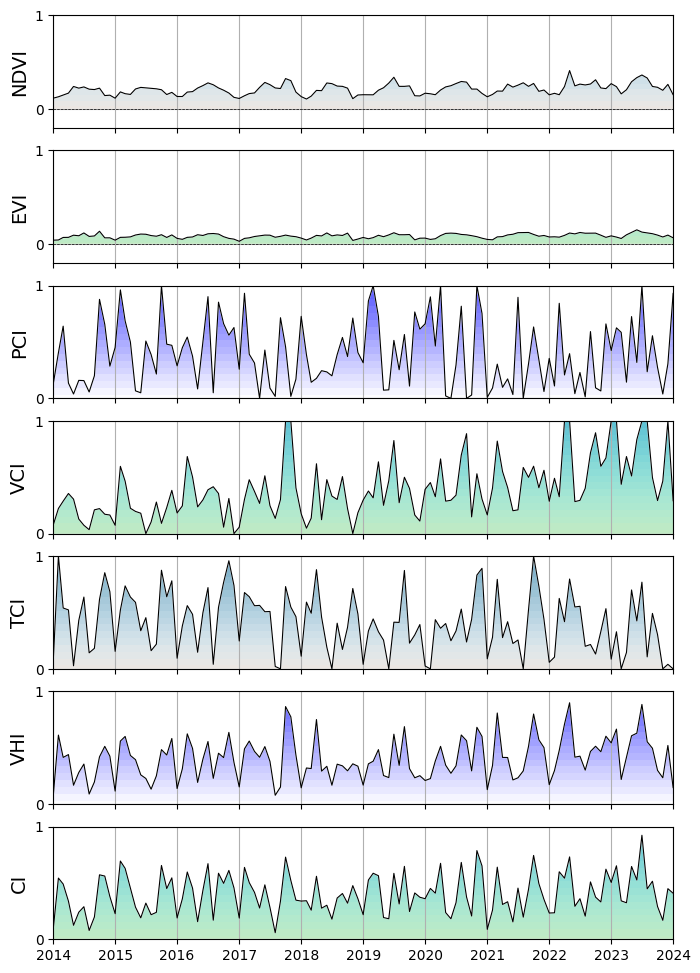

In [93]:
df_plot = df.query('Station_Name == "Bandar-e-anzali"')
df_plot.set_index('Date', inplace=True)

f, ax = plt.subplots(7, 1, figsize=(8, 12), sharex=True)
spei.plot.si(df_plot['NDVI'], ax=ax[0], cmap="vik_r")
spei.plot.si(df_plot['EVI'], ax=ax[1], cmap="roma")
spei.plot.si(df_plot['PCI_GPM'], ax=ax[2], cmap="seismic_r")
spei.plot.si(df_plot['VCI'], ax=ax[3], cmap="roma")
spei.plot.si(df_plot['TCI'], ax=ax[4], cmap="vik_r")
spei.plot.si(df_plot['VHI'], ax=ax[5], cmap="seismic_r")
spei.plot.si(df_plot['CI_GPM'], ax=ax[6], cmap="roma")
ax[0].set_xlim(pd.to_datetime(["2014", "2024"]))
ax[0].set_ylim(-0.2, 1)
ax[1].set_ylim(-0.2, 1)
ax[2].set_ylim(0, 1)
ax[3].set_ylim(0, 1)
ax[4].set_ylim(0, 1)
ax[5].set_ylim(0, 1)
ax[6].set_ylim(0, 1)
[x.grid() for x in ax]
[ax[i].set_ylabel(n, fontsize=14) for i, n in enumerate(['NDVI', 'EVI', 'PCI', 'VCI', 'TCI', 'VHI', 'CI'])];